In [ ]:
from damn import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# verify the cell responds to right contrasts

from damn.alignment import compute_spike_count
from spks.viz import plot_event_aligned_raster
from spks.utils import gaussian_function

#BWMS = 1
BWMS = 3
BWMS = 5
#BWMS = 25
#BWMS = 100
master_alignment_times = trials.stimOn_times
pres = .5
posts = 1.4
bwidth = BWMS / 1000

all = []
for s in spike_times:
    peth, timebin_centers, event_ind = compute_spike_count(master_alignment_times, s, pre_seconds=pres, post_seconds=posts, binwidth_s=BWMS/1000)
    all.append(peth)
peth = np.stack(all)
n_units, n_trials, samples_per_trial = peth.shape

In [21]:
print(n_trials, samples_per_trial)
Y = np.reshape(peth, (n_units, n_trials*samples_per_trial,), order='C').T
#Y = np.hstack([Y, np.ones_like(Y)])

1085 379


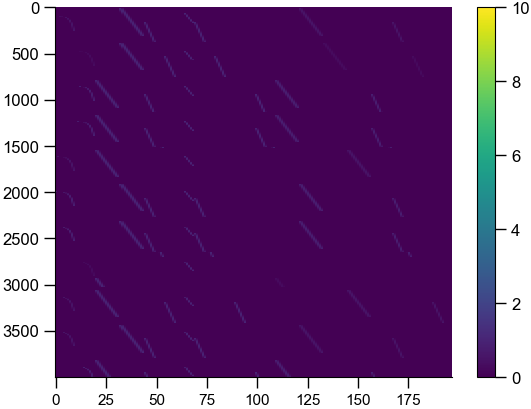

In [25]:
#plt.imshow(dmat[2000:4000,:], aspect='auto',interpolation='none')
c = 10
im = plt.imshow(dmat[0000:4000,:], aspect='auto',interpolation='none', clim=(0,c))
# add colorbar
plt.colorbar(im)
#plt.imshow(X[0000:20000,:], aspect='auto',interpolation='none')
#plt.imshow(X[2000:2050,:], aspect='auto',interpolation='none')

In [ ]:
X.shape, Y.shape

((411215, 197), (411215, 28))

In [27]:
from sklearn.linear_model import PoissonRegressor, Ridge, LinearRegression
from sklearn.multioutput import MultiOutputRegressor
# now fit models and get coefficients back
model = PoissonRegressor(alpha=0)
model = MultiOutputRegressor(PoissonRegressor(alpha=1e-7,max_iter=10000), n_jobs=1) #TODO: penalize
#model = LinearRegression()
model.fit(X, Y)
#coefs = model.coef_.flatten()
bias = [m.intercept_ for m in model.estimators_]
coefs = [np.array(m.coef_).flatten() for m in model.estimators_]
bias = np.squeeze(bias)
if np.ndim(bias) == 0:
    bias = np.array([bias])
coefs = np.stack(coefs)

# zscore columns for speed?
#Yhat = model.predict(X)

In [28]:
## now crossvalidate this
#from sklearn.model_selection import KFold, cross_val_score
#kf = KFold(n_splits=5, shuffle=True, random_state=42)
#model = PoissonRegressor(alpha=0)
#Ycval = Y[:,1:3]
#for i in range(Ycval.shape[1]):
#    scores = cross_val_score(model, X, Ycval[:,i], cv=kf, scoring='d2_absolute_error_score', n_jobs=5)
#    print(np.mean(scores))

In [29]:
#for i in range(Y.shape[1]):
#    model.fit(X,Y[:,i])
#    print(model.score(X,Y[:,i]))

In [30]:
Y.shape, X.shape, coefs.T.shape

((411215, 28), (411215, 197), (197, 28))

In [31]:
dmat.set_coefficients(coefs.T)

In [32]:
#dmat.right_stim.kernel_summary() , dmat.regressor_summary()
#dmat.regressor_summary(tag='stimulus')
#xx = dmat.X_for_tag('stimulus')
#coef = dmat.coefficients_for_tag('stimulus')

{'probe_num': np.int64(5), 'unit_id': np.int64(289)}


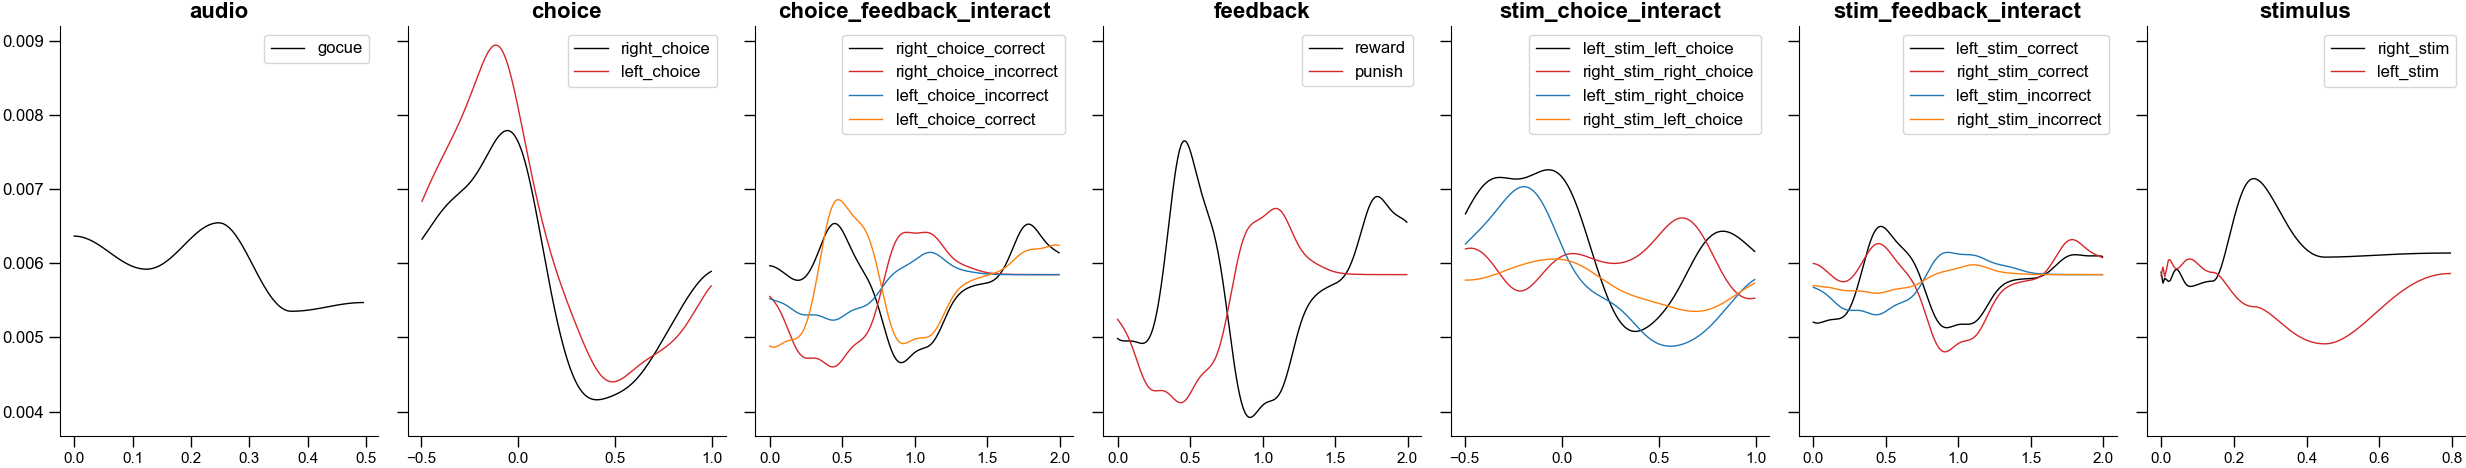

In [33]:
# plot kernels
ind = -6

linkfunc = model.estimators_[0]._base_loss.link.inverse
# get the unique tags from dmat
all_tags = []
for regname,reg in dmat.regressors.items():
    all_tags.extend(reg.tags)
all_tags = np.unique(all_tags)
all_tags = [t for t in all_tags if t != 'task']
all_tags = [t for t in all_tags if t != 'interaction']

# make subplots for each tag
fig, axs = plt.subplots(1,len(all_tags), figsize=(25,5), sharey=True)
if len(all_tags) == 1:
    axs = [axs]

for i,tag in enumerate(all_tags):
    regs = dmat.select(tag=tag)
    for r,reg in regs.items():
        k,t = reg.reconstruct_kernel()
        k = k[:,ind]
        k = linkfunc(k + bias[ind])
        axs[i].plot(t, k, label=reg.name)
    axs[i].set_title(tag)
    if tag not in ['history','dlc','video']:
        axs[i].legend()

plt.tight_layout()

print(query.fetch('probe_num','unit_id',as_dict=True)[ind])


In [24]:
Yhat = model.predict(X)

In [25]:
from damn.crossval import bits_per_spike_multi_target
bits_per_spike_multi_target(Y, Yhat)

[np.float64(0.46880067060134506),
 np.float64(0.39625853575970044),
 np.float64(0.37883222859487775),
 np.float64(0.47834493334400335),
 np.float64(0.09939986800920239),
 np.float64(0.6248149598085859),
 np.float64(0.06825492507264076),
 np.float64(0.3167169563237683),
 np.float64(0.048344944588637605),
 np.float64(0.11462067048383835),
 np.float64(0.15359797295321018),
 np.float64(0.6883547367232186),
 np.float64(0.04034967579491215),
 np.float64(0.7235634057652616),
 np.float64(0.0588799096387429),
 np.float64(0.11662970050597316),
 np.float64(0.6128757295563769),
 np.float64(0.1557206775089478),
 np.float64(0.13663135733733406),
 np.float64(0.0831559426541091),
 np.float64(0.09894246319092),
 np.float64(0.10950354644414707),
 np.float64(0.1229002522485299),
 np.float64(0.5075076093547654),
 np.float64(0.01909947005636459),
 np.float64(0.03560117276940815),
 np.float64(0.01108943719083378),
 np.float64(0.03388194823570537)]

In [ ]:
# check best alpha for single cells
from damn.crossval import bits_per_spike
from sklearn.model_selection import train_test_split
ind = -4
alphas = np.logspace(-8, 0, 10)
scores = []

Xsmall = X[:1000]
Ysmall = Y[:1000,ind]

for a in tqdm(alphas):
    model = PoissonRegressor(alpha=a, max_iter=10000)
    # randomly split into train and test
    model.fit(Xsmall, Ysmall)
    Y_pred = model.predict(Xsmall)
    scores.append(bits_per_spike(Ysmall, Y_pred))

best_alpha = alphas[np.argmax(scores)]

In [ ]:
best_alpha # seems like 1e-5 to 1e-6

In [ ]:
plt.plot(alphas,scores)
plt.xscale('log')

In [ ]:
from sklearn.linear_model import PoissonRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import make_scorer
from damn.crossval import bits_per_spike_multi_target

base_model = PoissonRegressor(max_iter=1000)
multi_model = MultiOutputRegressor(base_model)

param_dist = {
    "estimator__alpha": loguniform(1e-6, 1e2)  # IMPORTANT: prefix with estimator__
}

scorer = make_scorer(
    bits_per_spike,
    greater_is_better=True
)
scorer = 'neg_mean_poisson_deviance'

search = RandomizedSearchCV(
    multi_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring=scorer,
    #n_jobs=-1,
)

search.fit(X, Y)   # Y shape (n_samples, n_outputs)